In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.76871012 0.75       0.24       0.24      ]
 [0.44338401 0.25       0.15793987 0.33347618]]
[1. 0.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = (j+0.5)/W
        anchors[i,j,:,1] = (i+0.5)/H
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

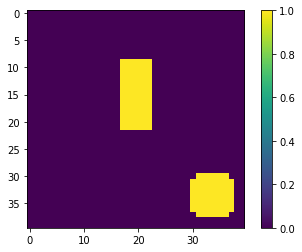

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 10000
lr         = 0.0001
print_step = 1000

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=10, hidden_size=256)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0813 10:24:41.777219 140546246522624 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0813 10:24:41.779328 140546246522624 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:13: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0813 10:24:41.780398 140546246522624 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0813 10:24:41.847846 140546246522624 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Sum:0", shape=(), dtype=float32) Tensor("mul_3:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.5f}, lab_sum={:.3f}".format(i,l, lc, lb, ls))

iteration 0: loss=4370.648 loss_class=4313.583 loss_box=57.06505, lab_sum=58.000
iteration 1000: loss=38.748 loss_class=33.532 loss_box=5.21594, lab_sum=10.000
iteration 2000: loss=33.251 loss_class=26.134 loss_box=7.11714, lab_sum=48.000
iteration 3000: loss=70.446 loss_class=69.611 loss_box=0.83445, lab_sum=6.000
iteration 4000: loss=14.169 loss_class=5.010 loss_box=9.15870, lab_sum=84.000
iteration 5000: loss=13.383 loss_class=6.910 loss_box=6.47359, lab_sum=84.000
iteration 6000: loss=26.558 loss_class=16.404 loss_box=10.15384, lab_sum=51.000
iteration 7000: loss=56.009 loss_class=33.495 loss_box=22.51333, lab_sum=48.000
iteration 8000: loss=13.871 loss_class=4.157 loss_box=9.71422, lab_sum=72.000
iteration 9000: loss=4.207 loss_class=1.688 loss_box=2.51822, lab_sum=26.000


In [10]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

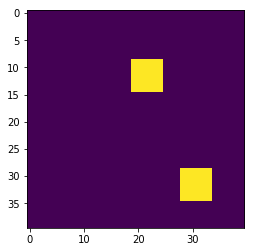

0


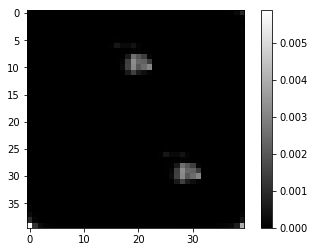

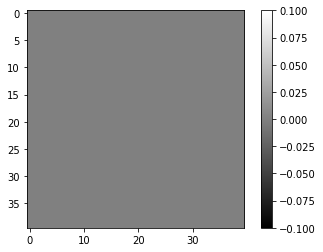

1


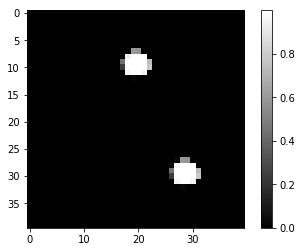

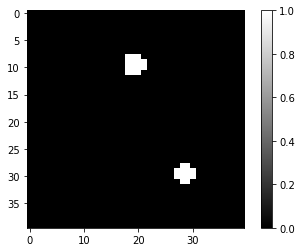

2


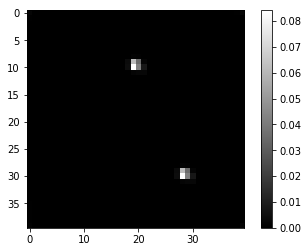

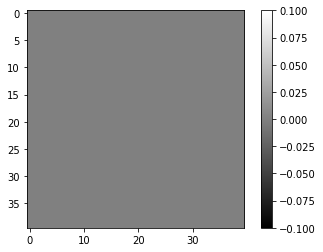

3


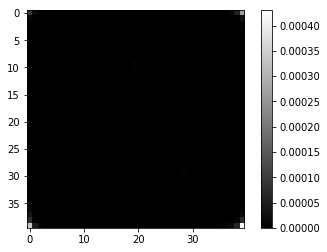

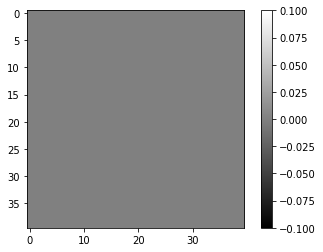

weights
0


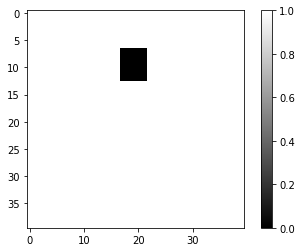

1


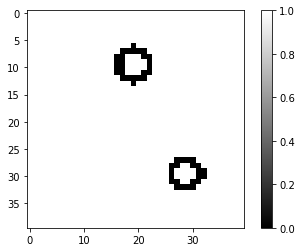

2


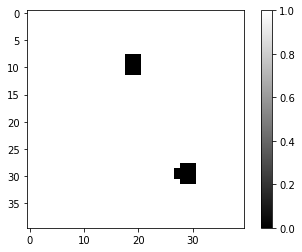

3


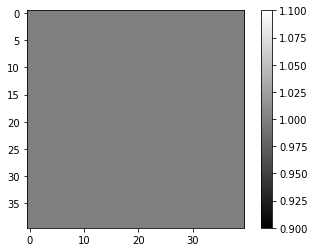

In [11]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [12]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [16]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.99]
print(anch_p)

[[0.4875 0.2125 0.2    0.2   ]
 [0.5125 0.2125 0.2    0.2   ]
 [0.5375 0.2125 0.2    0.2   ]
 [0.4625 0.2375 0.2    0.2   ]
 [0.4875 0.2375 0.2    0.2   ]
 [0.5125 0.2375 0.2    0.2   ]
 [0.5375 0.2375 0.2    0.2   ]
 [0.4625 0.2625 0.2    0.2   ]
 [0.4875 0.2625 0.2    0.2   ]
 [0.5125 0.2625 0.2    0.2   ]
 [0.5375 0.2625 0.2    0.2   ]
 [0.4875 0.2875 0.2    0.2   ]
 [0.5125 0.2875 0.2    0.2   ]
 [0.7125 0.7125 0.2    0.2   ]
 [0.7375 0.7125 0.2    0.2   ]
 [0.7625 0.7125 0.2    0.2   ]
 [0.6875 0.7375 0.2    0.2   ]
 [0.7125 0.7375 0.2    0.2   ]
 [0.7375 0.7375 0.2    0.2   ]
 [0.7625 0.7375 0.2    0.2   ]
 [0.6875 0.7625 0.2    0.2   ]
 [0.7125 0.7625 0.2    0.2   ]
 [0.7375 0.7625 0.2    0.2   ]
 [0.7625 0.7625 0.2    0.2   ]
 [0.7125 0.7875 0.2    0.2   ]
 [0.7375 0.7875 0.2    0.2   ]]


In [17]:
bp = predicted_boxes[predicted_obj>0.99]
print(bp)

[[ 0.0615868   0.12857804 -0.2077997  -0.15699361]
 [-0.03558718  0.13749148 -0.22413571 -0.1546398 ]
 [-0.11052547  0.11570206 -0.19743644 -0.11681629]
 [ 0.1678029   0.03720134 -0.21890743 -0.19481221]
 [ 0.06742286  0.03680661 -0.22135548 -0.20188239]
 [-0.05042017  0.04862282 -0.2076251  -0.2010522 ]
 [-0.11827777  0.04527889 -0.21724008 -0.18805106]
 [ 0.15106171 -0.07368108 -0.21969986 -0.20754714]
 [ 0.05666928 -0.06984803 -0.21777345 -0.19952959]
 [-0.04637773 -0.06441736 -0.21230124 -0.19920008]
 [-0.12437773 -0.07098728 -0.23139313 -0.19609542]
 [ 0.03769497 -0.1869265  -0.20557316 -0.16887046]
 [-0.04029995 -0.17728853 -0.21725181 -0.16792281]
 [ 0.0615868   0.12857804 -0.2077997  -0.15699361]
 [-0.03558718  0.13749148 -0.22413571 -0.1546398 ]
 [-0.11052547  0.11570206 -0.19743644 -0.11681629]
 [ 0.1678029   0.03720134 -0.21890743 -0.19481221]
 [ 0.06742286  0.03680661 -0.22135548 -0.20188239]
 [-0.05042017  0.04862282 -0.2076251  -0.2010522 ]
 [-0.11827777  0.04527889 -0.21

In [18]:
gt_p = gt_t[predicted_obj>0.99]
print(gt_p)

[[ 0.00434534  0.1875     -0.16206533 -0.16791834]
 [-0.12065466  0.1875     -0.16206533 -0.16791834]
 [-0.24565466  0.1875     -0.16206533 -0.16791834]
 [ 0.12934534  0.0625     -0.16206533 -0.16791834]
 [ 0.00434534  0.0625     -0.16206533 -0.16791834]
 [-0.12065466  0.0625     -0.16206533 -0.16791834]
 [-0.24565466  0.0625     -0.16206533 -0.16791834]
 [ 0.12934534 -0.0625     -0.16206533 -0.16791834]
 [ 0.00434534 -0.0625     -0.16206533 -0.16791834]
 [-0.12065466 -0.0625     -0.16206533 -0.16791834]
 [-0.24565466 -0.0625     -0.16206533 -0.16791834]
 [ 0.00434534 -0.1875     -0.16206533 -0.16791834]
 [-0.12065466 -0.1875     -0.16206533 -0.16791834]
 [ 0.08645217  0.1875     -0.24589343 -0.18250106]
 [-0.03854783  0.1875     -0.24589343 -0.18250106]
 [-0.16354783  0.1875     -0.24589343 -0.18250106]
 [ 0.21145217  0.0625     -0.24589343 -0.18250106]
 [ 0.08645217  0.0625     -0.24589343 -0.18250106]
 [-0.03854783  0.0625     -0.24589343 -0.18250106]
 [-0.16354783  0.0625     -0.24

In [19]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

[[19.99269441  9.5286243   6.49895811  6.83767605]
 [20.21530256  9.59993184  6.39365339  6.85378981]
 [20.61579621  9.4256165   6.5666585   7.11798906]
 [19.8424232   9.7976107   6.42716885  6.58391333]
 [20.03938287  9.79445285  6.41145372  6.53752804]
 [20.09663865  9.88898256  6.50009251  6.54295778]
 [20.55377787  9.86223111  6.43789387  6.62857914]
 [19.70849371  9.91055137  6.42207766  6.50059938]
 [19.95335427  9.94121575  6.43446112  6.55292797]
 [20.12897813  9.9846611   6.46976852  6.55508757]
 [20.50497812  9.93210179  6.34741974  6.57547045]
 [19.80155978 10.00458801  6.51344442  6.75694656]
 [20.17760038 10.08169174  6.43781853  6.76335287]
 [28.99269441 29.5286243   6.49895811  6.83767605]
 [29.21530256 29.59993184  6.39365339  6.85378981]
 [29.61579621 29.4256165   6.5666585   7.11798906]
 [28.8424232  29.7976107   6.42716885  6.58391333]
 [29.03938287 29.79445285  6.41145372  6.53752804]
 [29.09663865 29.88898256  6.50009251  6.54295778]
 [29.55377787 29.86223111  6.43

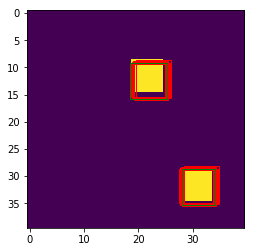

In [20]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    b_ = b*(H-1)
    rect = patches.Rectangle((b_[0]-0.5,b_[1]-0.5),b_[2],b_[3],linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    b_ = b*(H-1)
    rect = patches.Rectangle((b_[0]-0.5,b_[1]-0.5),b_[2],b_[3],linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()